In [1]:
import importlib
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import SRRS
from SRRS import plotting, utils
import importlib

## Identifying and plotting genes which have correlated spatial/buildup scores

Correlating using the reads directly from the .bam

In [147]:
#Need to specify multiple "reference" files

#this bam is from BICCN_10Xv3 has cell-type and sample of origin information as XO and RG tags respectively
#below is an example of how the tags are accessed
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'

with pysam.AlignmentFile(bam_path) as bam:
    r = next(bam.fetch())
    tags = [(k,v) for k,v in r.get_tags() if k in ['XO','RG']]
    print(tags)
    
#mouse gtf file to be able to plot exons/introns/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')


[('XO', 'L23_IT'), ('RG', 'L8TX_190430_01_A08:0:1:HJVYJDSXX:1')]


In [3]:
#read in all gene/cell info for both mice over all metrics (this is a large table)
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
gene_cell_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_cells))
gene_cell_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
0,puncta,208216926404047031835800982290964847257,Endo,197,Cxcl14,3,-0.488000,0.334000,BICCN_mouse1,m1s1
1,puncta,208216926404047031835800982290964847257,Endo,197,Flt1,66,0.458000,0.334000,BICCN_mouse1,m1s1
2,puncta,208216926404047031835800982290964847257,Endo,197,Aqp4,2,-0.250000,0.334000,BICCN_mouse1,m1s1
3,puncta,208216926404047031835800982290964847257,Endo,197,Acta2,3,-0.848000,0.334000,BICCN_mouse1,m1s1
4,puncta,208216926404047031835800982290964847257,Endo,197,Timp3,17,0.566000,0.334000,BICCN_mouse1,m1s1
...,...,...,...,...,...,...,...,...,...,...
4669863,central,294934189382673171666904576213325444817,L5_IT,268,Tmem163,1,-0.303371,0.335830,BICCN_mouse2,m2s6
4669864,central,294934189382673171666904576213325444817,L5_IT,268,Tox,9,-0.198502,0.088846,BICCN_mouse2,m2s6
4669865,central,294934189382673171666904576213325444817,L5_IT,268,Trpc4,3,-0.820225,0.199989,BICCN_mouse2,m2s6
4669866,central,294934189382673171666904576213325444817,L5_IT,268,Wipf3,14,-0.033708,0.055909,BICCN_mouse2,m2s6


In [8]:
#Fam19a2 gene synonym Tafa2 is used in the gtf. changing it to match the gene/cell table
#Fam84b gene synonym Lratd2 is used in the gtf. changing it to match the gene/cell table
gtf.loc[gtf['label'].eq('Tafa2'),'label'] = 'Fam19a2'
gtf.loc[gtf['label'].eq('Lratd2'),'label'] = 'Fam84b'

#Determine how many genes are present in both the gtf and the gene/cell table
gtf_genes = set(gtf['label'])
BICCN_genes = set(gene_cell_df['gene'])
shared_genes = BICCN_genes.intersection(gtf_genes)
BICCN_only_genes = BICCN_genes.difference(gtf_genes)

print('There are',len(gtf_genes),'unique genes in the gtf')
print('There are',len(BICCN_genes),'unique genes in the gene/cell table')
print('There are',len(shared_genes),'genes shared between both')
print('Genes present only in the gene/cell table',BICCN_only_genes)

#Determine which loci to plot by:
#1) selecting genes that are in both the gtf and the gene/cell table
#2) selecting on UTRs
#3) grouping by gene and expanding left to the 5'-most UTR start, and right to the 3'-most UTR end
#   this is important for genes with multiple annotated 3' UTRs
#4) add a bit of "padding" on either side of the locus as 5% of the span
loci = gtf[
    gtf['label'].isin(shared_genes) &
    gtf['kind'].eq('UTR')
][['label','chrom','start','end','strand']]

padding = loci['end'].subtract(loci['start']).multiply(0.05).astype(int)
loci['start'] -= padding
loci['end'] += padding

print('There are',len(loci),'loci to use for plotting')

There are 55228 unique genes in the gtf
There are 252 unique genes in the gene/cell table
There are 242 genes shared between both
Genes present only in the gene/cell table {'Blank-8', 'Blank-6', 'Blank-5', 'Blank-7', 'Blank-4', 'Blank-2', 'Blank-10', 'Blank-3', 'Blank-1', 'Blank-9'}
There are 2193 loci to use for plotting


Timp3 periph
     metric                                  cell_id annotation  num_spots  \
109  periph  222098490380092065288492113826920653088     L23_IT        521   
385  periph  324936583968035907461485415440119465532        Vip        229   
463  periph  212380056445062369967464310553750468306      L6_CT        522   
744  periph  214530813541466051618442266501415668881      L5_IT        555   
869  periph  208216926404047031835800982290964847257       Endo        230   

      gene  num_gene_spots     score  variance    experiment sample  
109  Timp3               2 -0.028846  0.166986  BICCN_mouse1   m1s1  
385  Timp3               7 -0.298246  0.109136  BICCN_mouse1   m1s1  
463  Timp3               2  0.928983  0.166985  BICCN_mouse1   m1s1  
744  Timp3               3  0.740072  0.199997  BICCN_mouse1   m1s1  
869  Timp3              17 -0.048035  0.049382  BICCN_mouse1   m1s1  
  Ontology    Window  Count  CDF
0    Astro  86297882      0  0.0
1    Astro  86297892      0  0.0

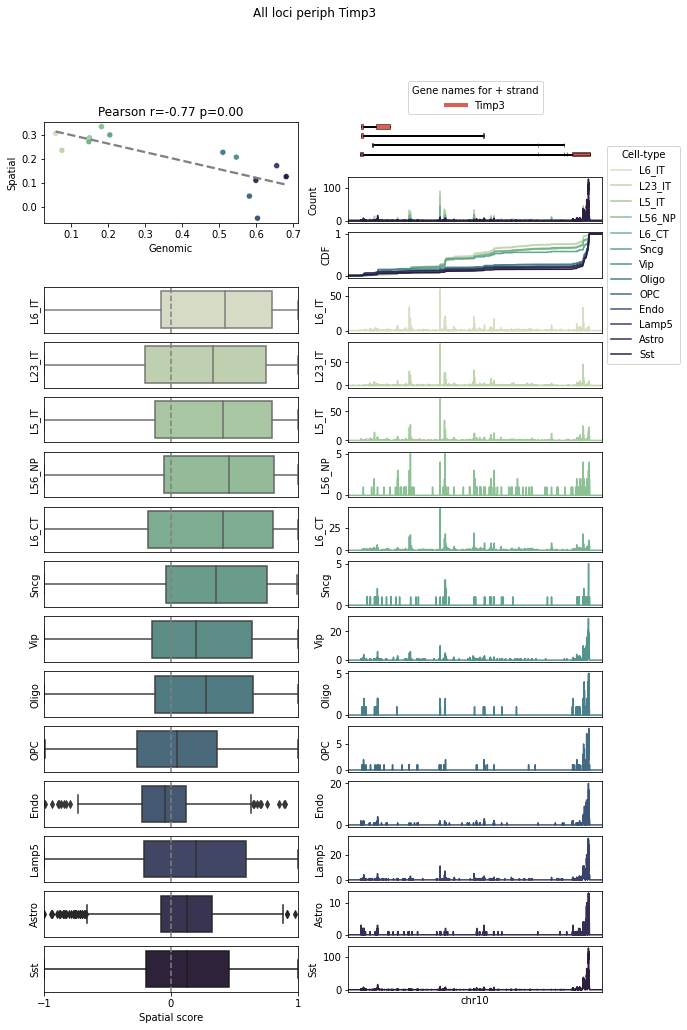

     metric                                  cell_id annotation  num_spots  \
109  periph  222098490380092065288492113826920653088     L23_IT        521   
385  periph  324936583968035907461485415440119465532        Vip        229   
463  periph  212380056445062369967464310553750468306      L6_CT        522   
744  periph  214530813541466051618442266501415668881      L5_IT        555   
869  periph  208216926404047031835800982290964847257       Endo        230   

      gene  num_gene_spots     score  variance    experiment sample  
109  Timp3               2 -0.028846  0.166986  BICCN_mouse1   m1s1  
385  Timp3               7 -0.298246  0.109136  BICCN_mouse1   m1s1  
463  Timp3               2  0.928983  0.166985  BICCN_mouse1   m1s1  
744  Timp3               3  0.740072  0.199997  BICCN_mouse1   m1s1  
869  Timp3              17 -0.048035  0.049382  BICCN_mouse1   m1s1  
Empty DataFrame
Columns: [Ontology, Window, Count, CDF]
Index: []
[]
     metric                               

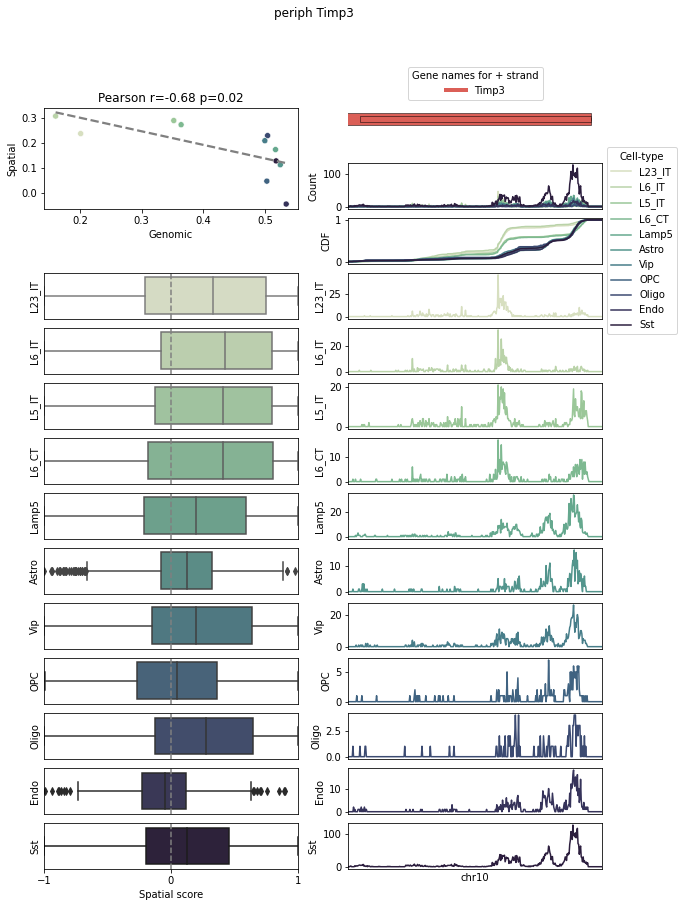

     metric                                  cell_id annotation  num_spots  \
109  periph  222098490380092065288492113826920653088     L23_IT        521   
385  periph  324936583968035907461485415440119465532        Vip        229   
463  periph  212380056445062369967464310553750468306      L6_CT        522   
744  periph  214530813541466051618442266501415668881      L5_IT        555   
869  periph  208216926404047031835800982290964847257       Endo        230   

      gene  num_gene_spots     score  variance    experiment sample  
109  Timp3               2 -0.028846  0.166986  BICCN_mouse1   m1s1  
385  Timp3               7 -0.298246  0.109136  BICCN_mouse1   m1s1  
463  Timp3               2  0.928983  0.166985  BICCN_mouse1   m1s1  
744  Timp3               3  0.740072  0.199997  BICCN_mouse1   m1s1  
869  Timp3              17 -0.048035  0.049382  BICCN_mouse1   m1s1  
Empty DataFrame
Columns: [Ontology, Window, Count, CDF]
Index: []
[]


In [148]:
#Plotting
#Iterate through all metric/gene combinations making buildup plots
importlib.reload(plotting)

for (metric,gene),g in gene_cell_df.groupby(['metric','gene']):
    if (gene != 'Timp3') or (metric != 'periph'): #NOTE, temporary
        continue
        
    print(gene,metric)
        
    if not gene in loci['label'].values:
        print('no loci for gene',gene,'found')
        continue
        
    #There can be multiple loci per gene (multiple 3' UTRs from different annotated isoforms)
    gene_loci = loci[loci['label'].eq(gene)].drop_duplicates()
    
    #Make an initial plot over all loci of the gene (span all annotated 3' UTRs)
    chrom,start,end = gene_loci['chrom'].iloc[0],gene_loci['start'].min(),gene_loci['end'].max()
    strand = gene_loci['strand'].iloc[0]
    padding = int(0.05*(end-start))
    start -= padding
    end += padding
    
    try:
        fig = plotting.read_buildup_plot(
            bam_path, locus=(chrom,start,end), strand=strand,
            ann_df=gtf, spatial_df=g,
            stratify_tag='XO', 
            ws=10, min_tag_reads=100,
        )
        if not fig:
            continue
        plt.suptitle(f'All loci {metric} {gene}')
        plt.show()
        plt.close()
    except:
        continue
       
    #Don't need to make the per-locus plots if this is just a single locus
    if len(gene_loci) == 1:
        continue
    
    #Make a separate plot per locus
    for _,locus in gene_loci.iterrows():
        chrom,start,end = locus['chrom'],locus['start'],locus['end']
        strand = locus['strand']
    
        try:
            fig = plotting.read_buildup_plot(
                bam_path, locus=(chrom,start,end), strand=strand,
                ann_df=gtf, spatial_df=g,
                stratify_tag='XO', 
                ws=10, min_tag_reads=100,
            )
            if not fig:
                continue
            plt.suptitle(f'{metric} {gene}')
            plt.show()
            plt.close()
        except:
            continue
    
    break #NOTE!

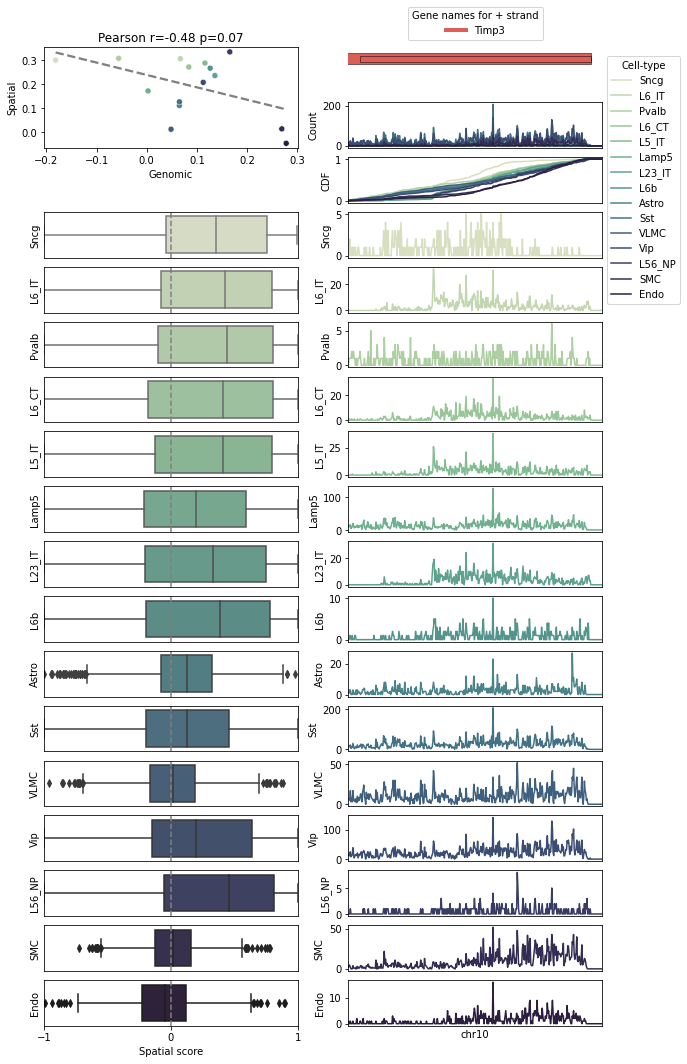

In [157]:
#Trying the SS2 bam
#this bam is from BICCN_SS2 has cell-type and sample of origin information as XO and RG tags respectively
importlib.reload(plotting)
bam_path_SS2 = '../../inputs/BICCN_SS2v4_scRNAseq.bam'

gene = 'Timp3'
metric = 'periph'
chrom,start,end = ('chr10', 86345720, 86349686)

g = gene_cell_df[
    gene_cell_df['gene'].eq(gene)
    & gene_cell_df['metric'].eq(metric)
]

#note, no strand since SS2 is unstranded
fig = plotting.read_buildup_plot(
    bam_path_SS2, locus=(chrom,start,end),
    ann_df=gtf, spatial_df=g,
    stratify_tag='XO', 
    ws=10, min_tag_reads=100,
)
plt.show()
plt.close()